# Retrieve all the relevant data from the table athletic-data in the database.
# Pre-requisite :
  1. Activity has to be of more than 2hrs.
  2. Watts and HeartRate column should not be null.

In [26]:
%reset
from src.repositories.PowerAndHRRepository import configs,get_athletic_data

athletic_data_db = get_athletic_data()

# DATA PROFILING : Removing irrelevant columns not required for analysis.

In [27]:
cols_to_ignore = configs.get("ignore-columns").data
athletic_data = athletic_data_db.drop(cols_to_ignore.split(","), axis=1).rename(columns={'watts' : 'power'})
athletic_data['distance'] = athletic_data['distance'].apply(lambda x: [float(value) for value in x])


# Check if the lengths of lists in specified columns are the same for each row


In [28]:
def check_lengths(row):
    columns_to_check = ['distance', 'heartrate', 'power', 'time']
    lengths = [len(row[col]) for col in columns_to_check]
    return all(length == lengths[0] for length in lengths)

# Apply the function to each row and count the activity IDs with different lengths
result = athletic_data[athletic_data.apply(check_lengths, axis=1)]
count_different_lengths = len(athletic_data) - len(result)

# Display the count of activity IDs with different lengths
print(f"Count of activity IDs with different lengths: {count_different_lengths}")

Count of activity IDs with different lengths: 0


# NA/NONE CHECK : Checking if watts or heartrate column contains null values

In [29]:

hr_contains_none = athletic_data['heartrate'].apply(lambda x: any(item is None for item in x) if x is not None else False).sum()
print(f"{hr_contains_none}/{len(athletic_data['heartrate'])} entries contains NA/NONE/null in heartrate")
watts_contains_none =  athletic_data['power'].apply(lambda x: any(item is None for item in x) if x is not None else False).sum()
print(f"{watts_contains_none}/{len(athletic_data['power'])}  entries contains NA/NONE/null in Power")
distance_contains_none =  athletic_data['distance'].apply(lambda x: any(item is None for item in x) if x is not None else False).sum()
print(f"{distance_contains_none}/{len(athletic_data['distance'])}  entries contains NA/NONE/null in Distance")
time_contains_none =  athletic_data['time'].apply(lambda x: any(item is None for item in x) if x is not None else False).sum()
print(f"{time_contains_none}/{len(athletic_data['time'])}  entries contains NA/NONE/null in Time")

0/251 entries contains NA/NONE/null in heartrate
225/251  entries contains NA/NONE/null in Power
0/251  entries contains NA/NONE/null in Distance
0/251  entries contains NA/NONE/null in Time


# Cluster view of how long the NA/None/Null entries exists.

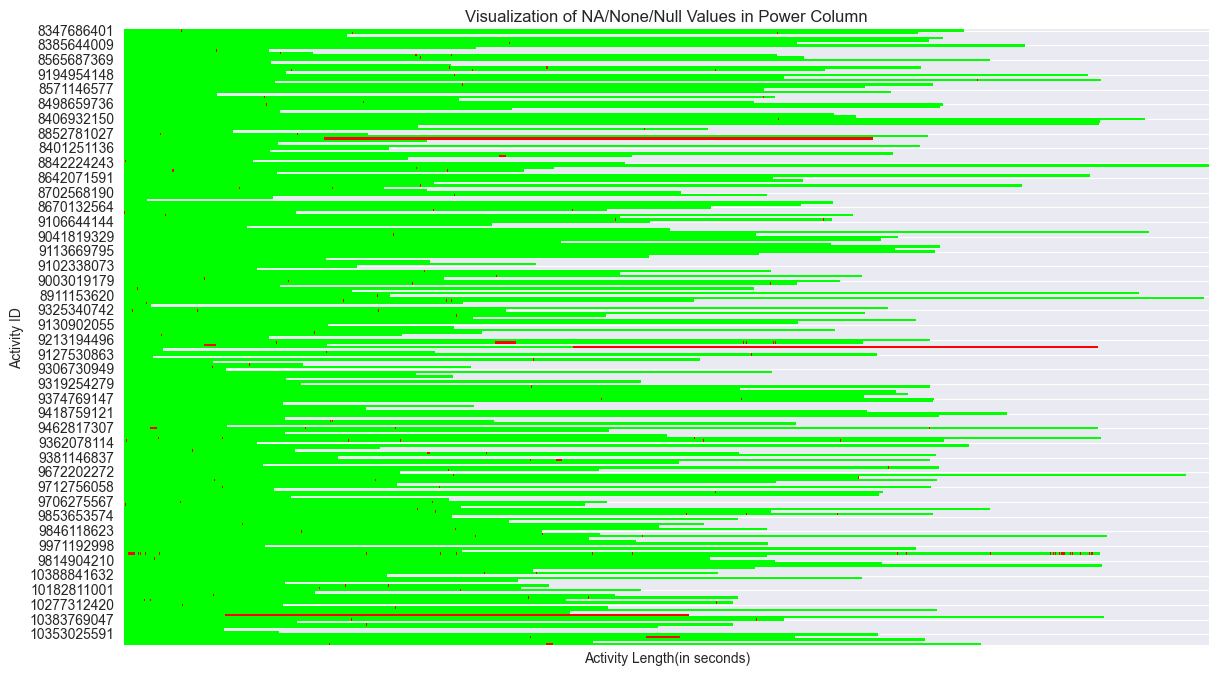

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

athletic_data_with_na = pd.DataFrame(index=athletic_data['activity_id'], columns=range(len(max(athletic_data['power'], key=len))))
 

for idx, powers in zip(athletic_data['activity_id'], athletic_data['power']):
    athletic_data_with_na.loc[idx, :len(powers) - 1] = pd.Series(powers).isna().values

athletic_data_with_na = athletic_data_with_na.astype(float)

cmap = sns.color_palette(['#00FF00', '#FF0000'])

# Create a line plot with color gradient
plt.figure(figsize=(14, 8))
sns.heatmap(data=athletic_data_with_na, cmap=cmap, cbar=False, xticklabels=False) 
plt.title('Visualization of NA/None/Null Values in Power Column')
plt.xlabel('Activity Length(in seconds)')
plt.ylabel('Activity ID')
plt.show()

# Visualization of the length of NA/None/Null Values in Power Column

# LINEAR INTERPOLATION For Missing Data in Power:


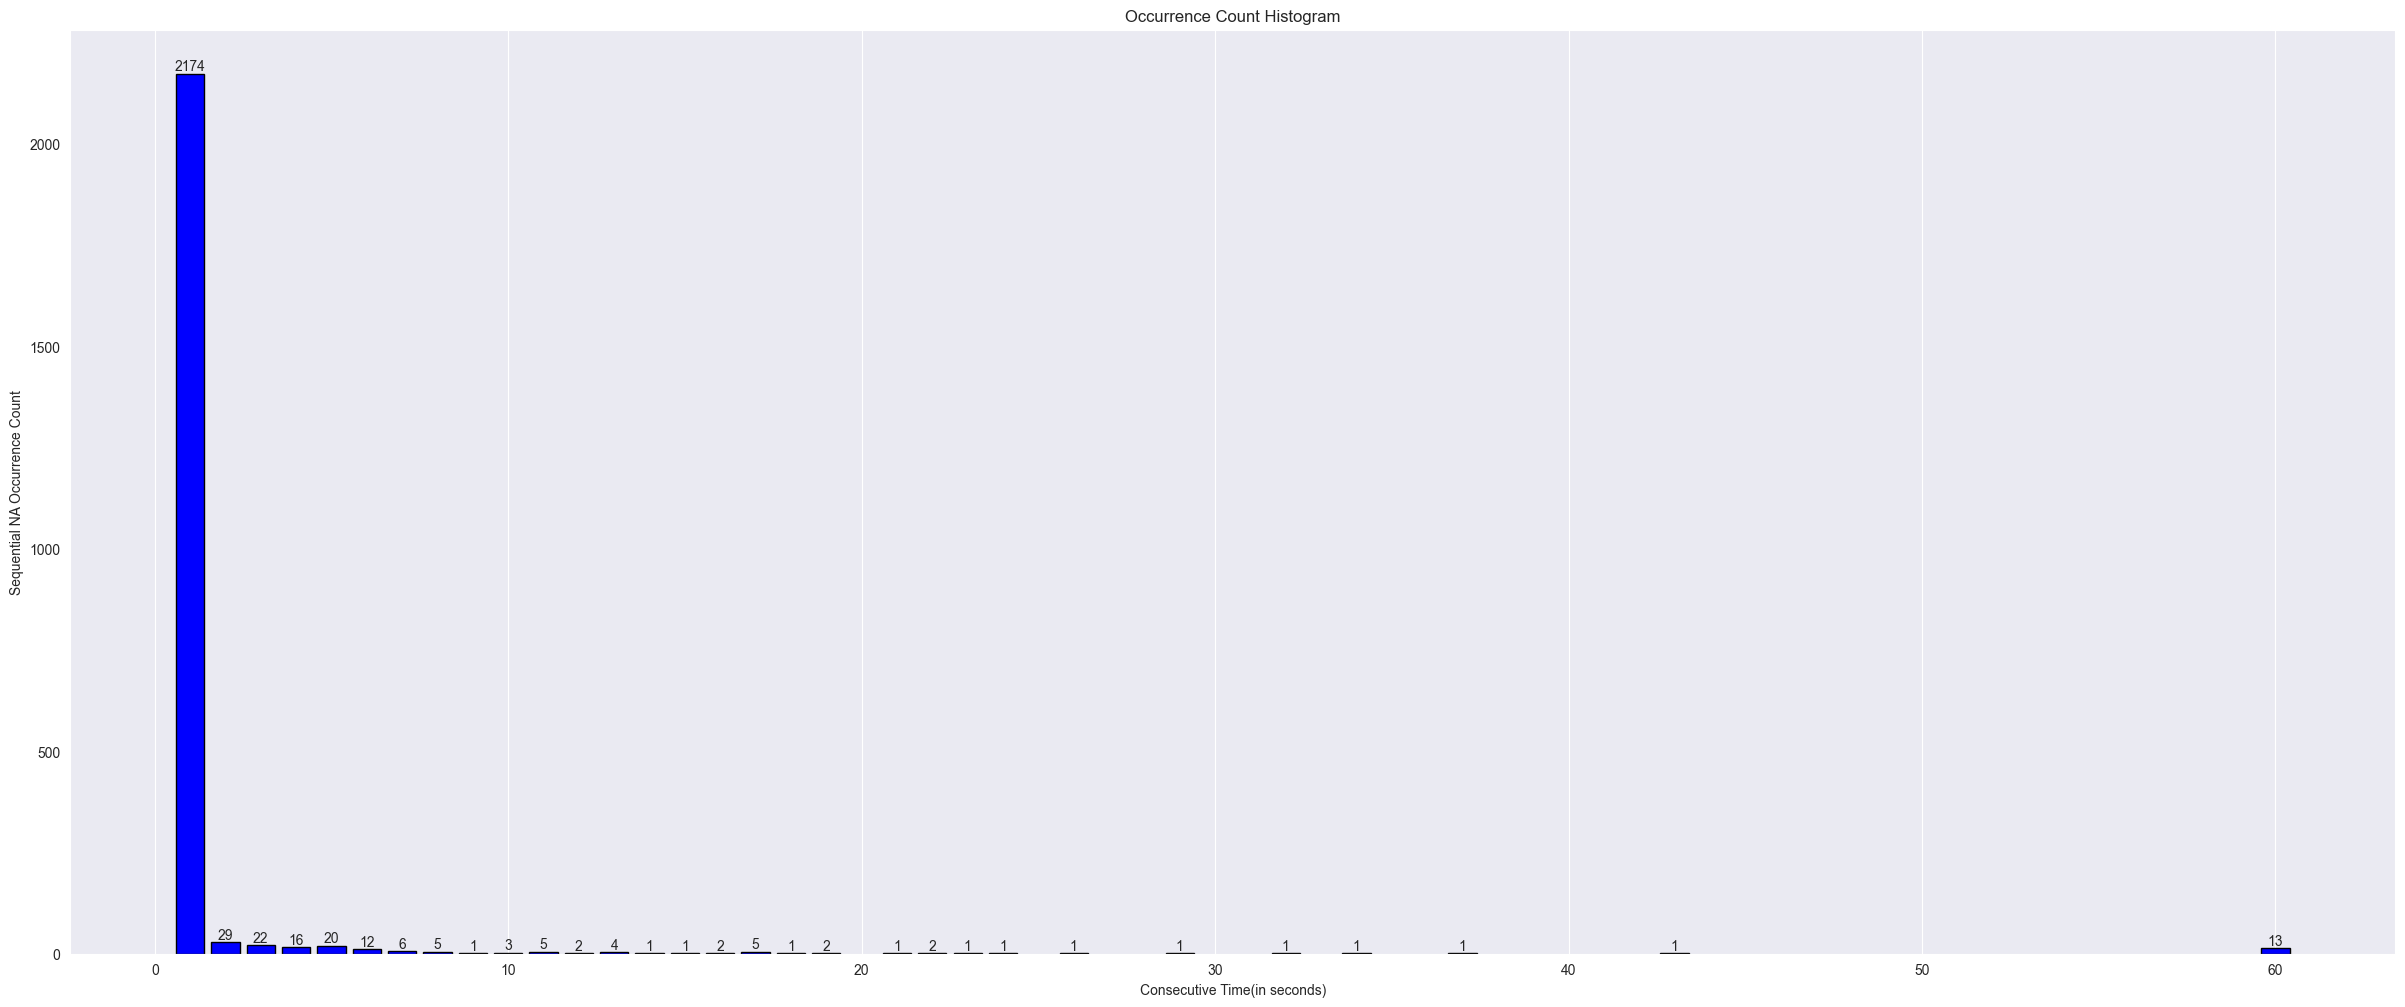

In [42]:
import matplotlib.pyplot as plt
from itertools import groupby
from collections import Counter

cons_na_pow_list = athletic_data['power'].apply(lambda x: [0] + [len(list(g)) for k, g in groupby(x) if k is None]).tolist()

def count_occurrences(na_list):
    flat_list = [min(num, 60) for sublist in na_list for num in sublist if num != 0]
    occurrences = Counter(flat_list)
    return dict(occurrences)

seq_na_occ_count = count_occurrences(cons_na_pow_list)

plt.figure(figsize=(30, 12))

plt.bar(seq_na_occ_count.keys(), seq_na_occ_count.values(), color='blue', edgecolor='black')

for key, value in seq_na_occ_count.items():
    plt.text(key, value, str(value), ha='center', va='bottom')


plt.title('Occurrence Count Histogram')
plt.xlabel('Consecutive Time(in seconds)')
plt.ylabel('Sequential NA Occurrence Count') 
plt.grid(axis='y')
plt.show()

# Converting Dataframe into CSV for further analysis in MATLAB

In [ ]:
import os
import pandas as pd

df = pd.DataFrame(athletic_data)

# Specify the path where you want to save the CSV file
athlete_name="Connor Swift"
athlete_id="863203"
year=2023

csv_directory = f'Strava Data/{athlete_name}'
csv_path = f'{csv_directory}/{athlete_name}_{athlete_id}_{year}.csv'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

df.to_csv(csv_path, index=False)


print(f"DataFrame has been successfully converted to CSV and saved at: {csv_path}")

#Overview of all the activities

In [ ]:
# Function to get the length of a list
get_list_length = lambda x: len(x) if isinstance(x, list) else 0

# Apply the function to create new columns
athletic_data['datapoints'] = athletic_data['power'].apply(get_list_length)


print(athletic_data)

# Choosing the longest continuous segments of each of the rides

In [ ]:
def find_longest_segment_indices(lst):
    if not lst:
        return [None, None]

    start_index, end_index = 0, 0
    current_start, current_end = 0, 0
    max_length = 1

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1] + 1:
            current_end = i
        else:
            current_start = i
            current_end = i

        current_length = current_end - current_start + 1

        if current_length > max_length:
            start_index, end_index = current_start, current_end
            max_length = current_length

    return [start_index, end_index]

athletic_data['longest_time_segment'] = athletic_data['time'].apply(find_longest_segment_indices)


Please ignore everything else below from here :




# NON-LINEAR/POLYNOMIAL REGRESSION For Missing Data :
#1. Power output/watts has similar variations as heartrate and heartrate has no missing entries(so model can rely on heartrate as the attribute to understand variations for watts and fill missing values.
#2. Power Output changes gradually on change of heart rate, not instantaneously.

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

def flatten_list(lst):
    flattened = []
    for item in lst:
        if isinstance(item, (list, tuple)):
            flattened.extend(flatten_list(item))
        else:
            flattened.append(item)
    return flattened

def convert_arrays_to_lists(arr):
    converted = []
    for item in arr:
        if isinstance(item, np.ndarray):
            converted.append(item.tolist())
        elif isinstance(item, (list, tuple)):
            converted.append(convert_arrays_to_lists(item))
        else:
            converted.append(item)
    return converted

def fill_none_with_regression(df, degree=2):
    df_copy = df.copy()
    X_train = []
    y_train = []
    # Prepare the training data
    for idx, row in df_copy.iterrows():
        heartrate = row['heartrate']
        watts = row['watts']
        mask = [w is not None for w in watts]  # Create a mask for non-None values
        watts_valid = np.array(watts)[mask]
        heartrate_valid = np.array(heartrate)[mask]
        X_train.extend([[x] for x in heartrate_valid])
        y_train.extend([[y] for y in watts_valid])
    # Perform polynomial regression
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_train)
    regressor = LinearRegression()
    regressor.fit(X_poly, y_train)
    # Fill the missing values
    for idx, row in df.iterrows():
        heartrate = row['heartrate']
        watts = row['watts']
        mask = [w is None or w == 0 for w in watts]  # Create a mask for None and 0 values
        if any(mask):
            heartrate_fill = np.array(heartrate)[mask].reshape(-1, 1)
            X_test = poly_features.transform(heartrate_fill)
            watts_fill = regressor.predict(X_test)
            # Replace the None and 0 values with the predicted values
            for i, value in enumerate(watts_fill):
                if watts[i] is None or watts[i] == 0:
                    watts[i] = value
            # Flatten the list of watts and convert arrays to lists
            watts_flat = flatten_list(watts)
            watts_flat = convert_arrays_to_lists(watts_flat)
            df.at[idx, 'watts'] = watts_flat
    return df
ad_filled = fill_none_with_regression(athletic_data, degree=2)
print(ad_filled)


# NOISE REDUCTION : Using Kalman Filtering Technique

from pykalman import KalmanFilter

def reduce_noise_kalman(data):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=data[0],
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.1)

    filtered_state_means, filtered_state_covariances = kf.filter(data)

    return filtered_state_means

athletic_data['heartrate'] = athletic_data['heartrate'].apply(reduce_noise_kalman)
athletic_data['watts'] = athletic_data['watts'].apply(reduce_noise_kalman)

# DATA DOWNSAMPLING : A data aggregation procedure where we decreasing the time-frequency of the data to plot on graph and visualise easily with less variations and minimizing abundance of values to process, making machine learning algorithms work faster.

# Function to downsample a column with None values
def downsample_column(arr, factor):
    downsampled_arr = []
    for i in range(0, len(arr), factor):
        segment = arr[i:i+factor]  # Extract a segment of the array based on the downsampling factor
        non_none_values = [value for value in segment if value is not None]  # Filter out None values
        if non_none_values:
            downsampled_arr.append(sum(non_none_values) / len(non_none_values))  # Calculate the average of non-None values
        else:
            downsampled_arr.append(None)  # Assign None if all values in the segment are None
    return downsampled_arr


athletic_data['heartrate'] = athletic_data['heartrate'].apply(lambda arr: downsample_column(arr,200))
athletic_data['power'] = athletic_data['power'].apply(lambda arr: downsample_column(arr,200))

#Saving Preprocessed DataSet : athletic_data

In [ ]:
%store athletic_data